# **Evaluation Metrics for Classification**

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
import pathlib
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
oldModuleCSV_FilePath = pathlib.Path.cwd().parent / "03-classification/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(oldModuleCSV_FilePath)

In [4]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.select_dtypes('object').columns)

for column in categorical_columns:
    df[column] = df[column].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [5]:
df_fulltrain, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_fulltrain, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [6]:
id = ['customerid']
numerical = ['tenure', 'monthlycharges', 'totalcharges']

mask = np.isin(df_fulltrain.columns, numerical + id)
categorical = df_fulltrain.columns[~mask].drop('churn')

In [7]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[list(categorical) + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [8]:
val_dicts = df_val[list(categorical) + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

np.float64(0.8026969481902059)

## **Accuracy and Dummy Model**

In [9]:
len(y_val)

1409

In [10]:
(y_val == churn_decision).mean()

np.float64(0.8026969481902059)

In [11]:
1132 / 1409

0.8034066713981547

In [12]:
from sklearn.metrics import accuracy_score

In [13]:
accuracy_score(y_val, y_pred >= 0.5)

0.8026969481902059

In [14]:
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    churn_decision = (y_pred >= t)
    score = (y_val == churn_decision).mean()
    
    if t == thresholds[0]:
        print('  t  | score')
    print('%.2f | %.3f' % (t, score))
    
    scores.append(score)

  t  | score
0.00 | 0.274
0.05 | 0.509
0.10 | 0.591
0.15 | 0.666
0.20 | 0.710
0.25 | 0.739
0.30 | 0.760
0.35 | 0.772
0.40 | 0.785
0.45 | 0.793
0.50 | 0.803
0.55 | 0.801
0.60 | 0.795
0.65 | 0.786
0.70 | 0.766
0.75 | 0.744
0.80 | 0.735
0.85 | 0.726
0.90 | 0.726
0.95 | 0.726
1.00 | 0.726


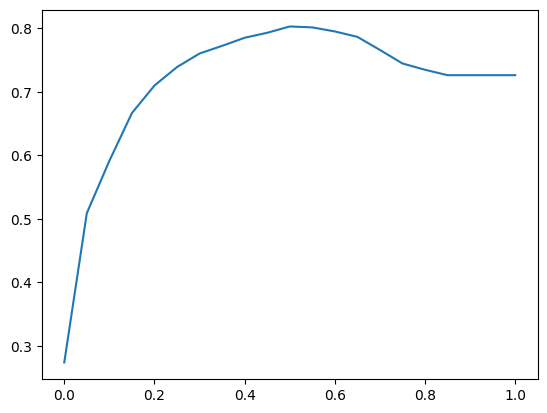

In [15]:
plt.plot(thresholds, scores)

In [16]:
from collections import Counter

In [17]:
Counter(y_pred >= 1.0)

Counter({np.False_: 1409})

Our model => 80%
Dummy model => 73%

The accuracy doesn't tell us how good the model is for this particular case because the distribution of y_val shows that 27% of customers are churning but 73% aren't.

In [18]:
Counter(y_val)

Counter({np.int64(0): 1023, np.int64(1): 386})

In [19]:
y_val.mean()

np.float64(0.2739531582682754)

In [20]:
1 - y_val.mean()

np.float64(0.7260468417317246)

## **Confusion Table**

In [21]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [22]:
t = 0.5

predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [23]:
actual_positive[:5]

array([False, False, False,  True, False])

In [24]:
predict_positive[:5]

array([False, False, False,  True, False])

In [25]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

In [26]:
tp, tn

(np.int64(210), np.int64(921))

In [27]:
fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [28]:
fp, fn

(np.int64(102), np.int64(176))

In [29]:
confusion_matrix = np.array([
    [tp, fn],
    [fp, tn]
])
confusion_matrix

array([[210, 176],
       [102, 921]])

In [30]:
((confusion_matrix / confusion_matrix.sum()) * 100).round(2)

array([[14.9 , 12.49],
       [ 7.24, 65.37]])

## **Precision and Recall**

In [31]:
(tp + tn) / (tp + tn + fn + fp)

np.float64(0.8026969481902059)

In [32]:
p = tp / (tp + fp)
p

np.float64(0.6730769230769231)

In [33]:
r = fp / (fp + tn)
r

np.float64(0.09970674486803519)

## **ROC Curves**

### **TPR and FRP**

In [34]:
tpr = tp / (tp + fn)
tpr

np.float64(0.5440414507772021)

In [35]:
fpr = fp / (fp + tn)
fpr

np.float64(0.09970674486803519)

In [36]:
scores = []

thresholds = np.linspace(0, 1, 101)
for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores.append((t, tp, fp, fn, tn))

scores

[(np.float64(0.0), np.int64(386), np.int64(1023), np.int64(0), np.int64(0)),
 (np.float64(0.01), np.int64(385), np.int64(914), np.int64(1), np.int64(109)),
 (np.float64(0.02), np.int64(384), np.int64(830), np.int64(2), np.int64(193)),
 (np.float64(0.03), np.int64(383), np.int64(766), np.int64(3), np.int64(257)),
 (np.float64(0.04), np.int64(381), np.int64(715), np.int64(5), np.int64(308)),
 (np.float64(0.05), np.int64(379), np.int64(685), np.int64(7), np.int64(338)),
 (np.float64(0.06), np.int64(377), np.int64(661), np.int64(9), np.int64(362)),
 (np.float64(0.07), np.int64(372), np.int64(641), np.int64(14), np.int64(382)),
 (np.float64(0.08), np.int64(371), np.int64(613), np.int64(15), np.int64(410)),
 (np.float64(0.09), np.int64(369), np.int64(580), np.int64(17), np.int64(443)),
 (np.float64(0.1), np.int64(366), np.int64(556), np.int64(20), np.int64(467)),
 (np.float64(0.11), np.int64(365), np.int64(528), np.int64(21), np.int64(495)),
 (np.float64(0.12), np.int64(365), np.int64(509), 

In [37]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

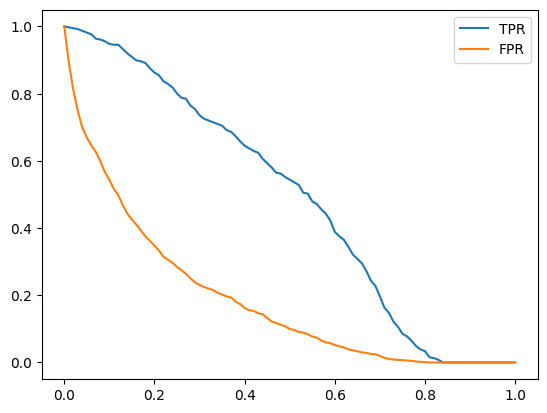

In [38]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

### **Random Model**

In [39]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [40]:
((y_rand >= 0.5) == y_val).mean()

np.float64(0.5017743080198722)

In [41]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []
    
    thresholds = np.linspace(0, 1, 101)
    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))
    
    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

    return df_scores

In [44]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

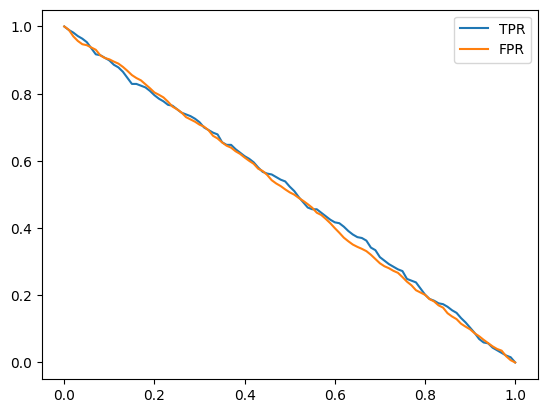

In [45]:
plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')
plt.legend()

## **Cross-Validation**